In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Hyundai.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Accent,Seri_Accent Blue,Seri_Accent Era,...,Model_2.0L TCI,Model_2.5 GLS,Model_3.0 GLS,Model_3.8,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,525750,2015,84,1248,130000,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,239000,2006,82,1493,244000,3.0,2.0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
2,375000,2012,85,1248,84000,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,439000,2008,115,1582,185000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,480000,2010,115,1582,187000,8.0,0.0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_14980\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,43181.735226,1.485936e+09,38547.845782,28530.890899


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:13:13,750] A new study created in memory with name: no-name-ee6ca30f-03b1-4956-98d5-ece91c904c39
[I 2023-10-08 14:13:14,098] Trial 2 finished with value: 403990.0934084203 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.005788498795126805, 'max_depth': 11, 'min_child_weight': 292}. Best is trial 2 with value: 403990.0934084203.
[I 2023-10-08 14:13:14,098] Trial 1 finished with value: 416616.87099422887 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.0024397516165797313, 'max_depth': 14, 'min_child_weight': 182}. Best is trial 2 with value: 403990.0934084203.
[I 2023-10-08 14:13:14,146] Trial 0 finished with value: 412300.21118043555 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.0035243275720556653, 'max_depth': 7, 'min_child_weight': 281}. Best is trial 2 with value: 403990.0934084203.
[I 2023-10-08 14:13:14,150] Trial 5 finished with value: 425282.41421123705 and parameters:

[I 2023-10-08 14:13:16,285] Trial 30 finished with value: 55824.98261300453 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.3376477887934912, 'max_depth': 5, 'min_child_weight': 72}. Best is trial 23 with value: 48435.86558726042.
[I 2023-10-08 14:13:16,301] Trial 31 finished with value: 53663.72152363727 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.36280542246478364, 'max_depth': 5, 'min_child_weight': 67}. Best is trial 23 with value: 48435.86558726042.
[I 2023-10-08 14:13:16,363] Trial 34 finished with value: 55780.35059482441 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4665817512085717, 'max_depth': 5, 'min_child_weight': 65}. Best is trial 23 with value: 48435.86558726042.
[I 2023-10-08 14:13:16,363] Trial 32 finished with value: 54880.15004230297 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.34541863132249573, 'max_depth': 5, 'min_child_weight': 68}

[I 2023-10-08 14:13:18,588] Trial 62 finished with value: 137948.58406942757 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.11668458527119718, 'max_depth': 6, 'min_child_weight': 50}. Best is trial 23 with value: 48435.86558726042.
[I 2023-10-08 14:13:18,620] Trial 60 finished with value: 43232.04183086443 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.31017286617175316, 'max_depth': 6, 'min_child_weight': 52}. Best is trial 60 with value: 43232.04183086443.
[I 2023-10-08 14:13:18,667] Trial 61 finished with value: 123786.71709556413 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.1274202006416458, 'max_depth': 8, 'min_child_weight': 16}. Best is trial 60 with value: 43232.04183086443.
[I 2023-10-08 14:13:18,713] Trial 63 finished with value: 116427.15415074781 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.13459338592275313, 'max_depth': 8, 'min_child_weight':

[I 2023-10-08 14:13:21,508] Trial 89 finished with value: 68949.6818699859 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.18713486006407792, 'max_depth': 10, 'min_child_weight': 42}. Best is trial 73 with value: 42893.600095933194.
[I 2023-10-08 14:13:21,796] Trial 91 finished with value: 43970.09818277721 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.38695335681151943, 'max_depth': 10, 'min_child_weight': 43}. Best is trial 73 with value: 42893.600095933194.
[I 2023-10-08 14:13:21,804] Trial 92 finished with value: 155068.54617558833 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.10090308509060872, 'max_depth': 10, 'min_child_weight': 28}. Best is trial 73 with value: 42893.600095933194.
[I 2023-10-08 14:13:22,036] Trial 94 finished with value: 65122.60036363605 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.39624651971536545, 'max_depth': 10, 'min_child_wei

[I 2023-10-08 14:13:24,910] Trial 120 finished with value: 43764.49120471032 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.4776992203798324, 'max_depth': 11, 'min_child_weight': 33}. Best is trial 101 with value: 40113.36510903759.
[I 2023-10-08 14:13:24,959] Trial 121 finished with value: 42754.580282139446 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4991557376839557, 'max_depth': 14, 'min_child_weight': 34}. Best is trial 101 with value: 40113.36510903759.
[I 2023-10-08 14:13:25,572] Trial 122 finished with value: 39520.30549131619 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.46880717947716494, 'max_depth': 11, 'min_child_weight': 8}. Best is trial 122 with value: 39520.30549131619.
[I 2023-10-08 14:13:25,684] Trial 124 finished with value: 41733.679046613615 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4889700769662878, 'max_depth': 11, 'min_child_w

[I 2023-10-08 14:13:28,580] Trial 150 finished with value: 39612.63811361781 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.34240293057762045, 'max_depth': 15, 'min_child_weight': 16}. Best is trial 147 with value: 39183.15363265973.
[I 2023-10-08 14:13:28,836] Trial 151 finished with value: 39607.616326263436 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.338592658939639, 'max_depth': 15, 'min_child_weight': 15}. Best is trial 147 with value: 39183.15363265973.
[I 2023-10-08 14:13:28,940] Trial 152 finished with value: 38858.91811547663 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.34516839914767966, 'max_depth': 15, 'min_child_weight': 13}. Best is trial 152 with value: 38858.91811547663.
[I 2023-10-08 14:13:29,108] Trial 153 finished with value: 39708.698702983835 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.337685149636275, 'max_depth': 15, 'min_child_w

[I 2023-10-08 14:13:33,724] Trial 180 finished with value: 40282.60510897441 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4029558211225871, 'max_depth': 15, 'min_child_weight': 25}. Best is trial 179 with value: 38215.68858507077.
[I 2023-10-08 14:13:33,835] Trial 181 finished with value: 39330.87502666057 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4258714003820651, 'max_depth': 15, 'min_child_weight': 23}. Best is trial 179 with value: 38215.68858507077.
[I 2023-10-08 14:13:33,835] Trial 182 finished with value: 40240.13496643349 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.3929071692073719, 'max_depth': 15, 'min_child_weight': 21}. Best is trial 179 with value: 38215.68858507077.
[I 2023-10-08 14:13:34,021] Trial 183 finished with value: 39603.469865698615 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4017907009080581, 'max_depth': 15, 'min_child_we

[I 2023-10-08 14:13:37,139] Trial 213 finished with value: 46416.84003525934 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.43119039973993095, 'max_depth': 15, 'min_child_weight': 108}. Best is trial 179 with value: 38215.68858507077.
[I 2023-10-08 14:13:37,139] Trial 212 finished with value: 191773.5896159189 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.08007794022716115, 'max_depth': 15, 'min_child_weight': 28}. Best is trial 179 with value: 38215.68858507077.
[I 2023-10-08 14:13:37,202] Trial 209 finished with value: 48591.66513019446 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.24275934558237872, 'max_depth': 15, 'min_child_weight': 26}. Best is trial 179 with value: 38215.68858507077.
[I 2023-10-08 14:13:37,217] Trial 214 finished with value: 420624.41353010334 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.0014208169077803356, 'max_depth': 15, 'min_c

[I 2023-10-08 14:13:40,973] Trial 241 finished with value: 44168.90115965533 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.2753655508387826, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 179 with value: 38215.68858507077.
[I 2023-10-08 14:13:41,011] Trial 242 finished with value: 43414.788780410156 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.2805041703570085, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 179 with value: 38215.68858507077.
[I 2023-10-08 14:13:41,014] Trial 240 finished with value: 41852.55174051856 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.2913558578485828, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 179 with value: 38215.68858507077.
[I 2023-10-08 14:13:41,139] Trial 243 finished with value: 41454.91603968921 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.28447147054042504, 'max_depth': 15, 'min_child_weig

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 38215.6886
Best params:
	colsample_bytree: 1.0
	subsample: 1.0
	learning_rate: 0.40598976338661197
	max_depth: 15
	min_child_weight: 15


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 47023.325106482334, 'MSE': 1674253086.5303497, 'RMSE': 40917.63784152685, 'MAE': 30850.581232492998}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9384420036868958

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9305488820429496

In [16]:
marka_model = joblib.dump(final_model, "Hyundai.pkl")

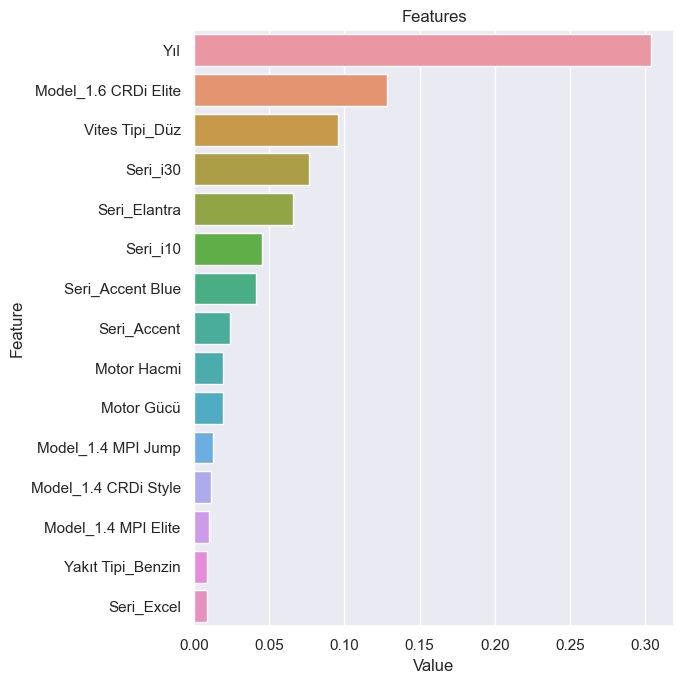

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)